In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml
import json
import pickle
import copy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

from mykaggle.metric.mse import rmse
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [2]:
seed = 1019

settings = yaml.safe_load(f'''
name: '193_publisher'
competition: atmacup8
description: 'count 高頻度のみ'
seed: {seed}
training:
    pca_dim: 4
    validation: 'group'
    num_folds: 5
    num_rounds: 10000
    early_stopping_rounds: 1000
    verbose_eval: 20
    sample_weight_division: 0.01  # 10/2/1
    sample_weight_threshold: 1000
feature:
    name_bow_pca_dim: 4
    name_bow_word_th1: 5
    name_bow_word_th2: 3
    name_bow_th1_upper: 130
    name_bow_th2_upper: 100
lgbm_params:
    # seed: {seed}
    objective: multiclass
    num_class: 81
    learning_rate: 0.02
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: multi_logloss
    verbose: -1
''')
print(json.dumps(settings, indent=4))

{
    "name": "193_publisher",
    "competition": "atmacup8",
    "description": "count \u9ad8\u983b\u5ea6\u306e\u307f",
    "seed": 1019,
    "training": {
        "pca_dim": 4,
        "validation": "group",
        "num_folds": 5,
        "num_rounds": 10000,
        "early_stopping_rounds": 1000,
        "verbose_eval": 20,
        "sample_weight_division": 0.01,
        "sample_weight_threshold": 1000
    },
    "feature": {
        "name_bow_pca_dim": 4,
        "name_bow_word_th1": 5,
        "name_bow_word_th2": 3,
        "name_bow_th1_upper": 130,
        "name_bow_th2_upper": 100
    },
    "lgbm_params": {
        "objective": "multiclass",
        "num_class": 81,
        "learning_rate": 0.02,
        "max_depth": -1,
        "num_leaves": 31,
        "colsample_bytree": 0.7,
        "metric": "multi_logloss",
        "verbose": -1
    }
}


/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
fix_seed(settings['seed'])

In [4]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [66]:
df_train = pd.read_csv(datadir / 'publisher_train2.csv')
df_test = pd.read_csv(datadir / 'id_test.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((7317, 22), (8360, 12))

In [6]:
# target や weight の用意
target_column = 'Publisher'
# train_target_columns = ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

# for c in train_target_columns:
#     df_train.loc[:, 'mod_' + c] = df_train.loc[:, c].apply(lambda x: np.log1p(x))
df_train['target'] = df_train.loc[:, f'{target_column}']
le = LabelEncoder()
df_train['target'] = le.fit_transform(df_train['target'])
num_classes = df_train['target'].nunique()
settings['lgbm_params']['num_class'] = num_classes

In [7]:
df_base_train = df_train.loc[:, ['id']]
df_base_test = df_test.loc[:, ['id']]

train_others = {
    'main': df_train.copy(),
    'another': df_test.copy()
}
test_others = {
    'main': df_test.copy(),
    'another': df_train.copy(),
}

In [8]:
from mykaggle.feature.le import LE
from mykaggle.feature.score import Score
from mykaggle.feature.score_tbd import ScoreTBD
from mykaggle.feature.multi_platform import MultiPlatform
from mykaggle.feature.other_platforms import OtherPlatforms
from mykaggle.feature.ce import CE
from mykaggle.feature.original import Original
from mykaggle.feature.platform_to_pub_genre_once import PlatformToPubGenreOnce
from mykaggle.feature.genre_to_all_once import GenreToAllOnce
from mykaggle.feature.dev_to_category import DevToCategory
from mykaggle.feature.pub_to_category import PubToCategory
from mykaggle.feature.pub_count_500 import PubCount500
from mykaggle.feature.dev_to_category_pivot_pca_all import DevToCategoryPivotPCAAll
from mykaggle.feature.pub_to_category_pivot_pca_all import PubToCategoryPivotPCAAll
from mykaggle.feature.name_bow2 import NameBOW2
from mykaggle.feature.has_sales import HasSales
from mykaggle.feature.name_series_count import NameSeriesCount

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [9]:
fhp = settings['feature']

original_train = Original(train=True)
original_test = Original(train=False)
le_train = LE(train=True)
le_test = LE(train=False)
score_train = Score(train=True)
score_test = Score(train=False)
score_tbd_train = ScoreTBD(train=True)
score_tbd_test = ScoreTBD(train=False)
mp_train = MultiPlatform(train=True)
mp_test = MultiPlatform(train=False)
op_train = OtherPlatforms(train=True)
op_test = OtherPlatforms(train=False)
ce_train = CE(train=True)
ce_test = CE(train=False)
dtc_train = DevToCategory(train=True)
dtc_test = DevToCategory(train=False)
# ptc_train = PubToCategory(train=True)
# ptc_test = PubToCategory(train=False)
dtcpa_train = DevToCategoryPivotPCAAll(train=True, n_components=2)
dtcpa_test = DevToCategoryPivotPCAAll(train=False, n_components=2)
# ptcpa_train = PubToCategoryPivotPCAAll(train=True, n_components=settings['training']['pca_dim'])
# ptcpa_test = PubToCategoryPivotPCAAll(train=False, n_components=settings['training']['pca_dim'])
pftao_train = PlatformToPubGenreOnce(train=True, n_components=4)
pftao_test = PlatformToPubGenreOnce(train=False, n_components=4)
gtao_train = GenreToAllOnce(train=True, n_components=4)
gtao_test = GenreToAllOnce(train=False, n_components=4)
# p500_train = PubCount500(train=True)
# p500_test = PubCount500(train=False)
nbow_train = NameBOW2(
    True, fhp['name_bow_pca_dim'], fhp['name_bow_word_th1'], fhp['name_bow_word_th2'],
    fhp['name_bow_th1_upper'], fhp['name_bow_th2_upper'],
)
nbow_test = NameBOW2(
    False, fhp['name_bow_pca_dim'], fhp['name_bow_word_th1'], fhp['name_bow_word_th2'],
    fhp['name_bow_th1_upper'], fhp['name_bow_th2_upper'],
)
# has_sales_train = HasSales(train=True)
# has_sales_test = HasSales(train=False)
nsc_train = NameSeriesCount(train=True)
nsc_test = NameSeriesCount(train=False)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
df_f_train = df_base_train.copy()
df_f_test = df_base_test.copy()

df_f_train = original_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = original_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = le_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = le_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = score_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = score_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = score_tbd_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = score_tbd_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = mp_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = mp_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = op_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = op_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = ce_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = ce_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = dtc_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = dtc_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
# df_f_train = ptc_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
# df_f_test = ptc_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = dtcpa_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = dtcpa_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
# df_f_train = ptcpa_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
# df_f_test = ptcpa_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = pftao_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = pftao_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = gtao_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = gtao_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
# df_f_train = p500_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
# df_f_test = p500_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = nbow_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = nbow_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
# df_f_train = has_sales_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
# df_f_test = has_sales_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = nsc_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = nsc_test(df_f_test, others=test_others, use_cache=False, save_cache=True)

df_f_train.shape, df_f_test.shape

((7317, 68), (8360, 68))

In [11]:
# drop some columns
df_f_train = df_f_train.drop(['le_Developer'], axis=1)
df_f_test = df_f_test.drop(['le_Developer'], axis=1)
df_f_train.shape, df_f_test.shape

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((7317, 67), (8360, 67))

In [12]:
pd.set_option('display.max_rows', 500)
df_f_train.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,0,1,2,3,4,5,6,7,8,9
Year_of_Release,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
le_Platform,25,25,18,0,25,27,16,16,27,16
le_Genre,0,0,0,0,0,0,0,0,0,0
le_Rating,2,2,2,6,2,2,5,2,5,5
Critic_Score,0.74,0.78,0.73,NaN,0.76,0.77,0.78,0.76,0.61,0.63
User_Score,0.79,0.66,0.74,NaN,0.78,0.79,0.8,0.83,0.74,0.7
Critic_Count,17,22,5,NaN,8,35,59,27,48,33
User_Count,22,28,10,NaN,13,39,177,48,113,100
is_tbd,False,False,False,False,False,False,False,False,False,False


In [13]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
from mykaggle.feature.te import TE
from mykaggle.feature.te_other_aggs import TEOtherAggs
from mykaggle.feature.te_year_platform import TEYearPlatform
from mykaggle.feature.te_year_genre import TEYearGenre
from mykaggle.feature.year_rank4 import YearRank4
from mykaggle.feature.platform_time_diff import PlatformTimeDiff


# te_train = TE(train=True)
# te_test = TE(train=False)
# te_oa_train = TEOtherAggs(train=True)
# te_oa_test = TEOtherAggs(train=False)
# te_yp_train = TEYearPlatform(train=True)
# te_yp_test = TEYearPlatform(train=False)
# te_yg_train = TEYearGenre(train=True)
# te_yg_test = TEYearGenre(train=False)
year_rank_train = YearRank4(train=True)
year_rank_test = YearRank4(train=False)
ptdiff_train = PlatformTimeDiff(train=True)
ptdiff_test = PlatformTimeDiff(train=False)


def get_oof_feature(
    df_train: pd.DataFrame, df_valid: pd.DataFrame, y_train: np.ndarray,
    df_train_original: pd.DataFrame, df_valid_original: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_train.loc[:, 'target'] = y_train.copy()
    _train_others = copy.deepcopy(train_others)
    _test_others = copy.deepcopy(test_others)
    _train_others['main'] = df_train_original.copy().reset_index().drop('index', axis=1)
    _train_others['another'] = df_valid_original.copy().reset_index().drop('index', axis=1)
    _test_others['main'] = df_valid_original.copy().reset_index().drop('index', axis=1)
    _test_others['another'] = df_train_original.copy().reset_index().drop('index', axis=1)
    df_train = df_train.reset_index().drop('index', axis=1)
    df_valid = df_valid.reset_index().drop('index', axis=1)
#     df_train = te_train(df_train, others=_train_others, use_cache=False, save_cache=False)
#     df_valid = te_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
#     df_train = te_oa_train(df_train, others=_train_others, use_cache=False, save_cache=False)
#     df_valid = te_oa_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
#     df_train = te_yp_train(df_train, others=_train_others, use_cache=False, save_cache=False)
#     df_valid = te_yp_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
#     df_train = te_yg_train(df_train, others=_train_others, use_cache=False, save_cache=False)
#     df_valid = te_yg_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
    df_train = year_rank_train(df_train, others=_train_others, use_cache=False, save_cache=False)
    df_valid = year_rank_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
    df_train = ptdiff_train(df_train, others=_train_others, use_cache=False, save_cache=True)
    df_valid = ptdiff_test(df_valid, others=_test_others, use_cache=False, save_cache=True)
    return df_train.drop(['id', 'target'], axis=1), df_valid.drop('id', axis=1)

In [15]:
def train(
    settings: Dict[str, Any],
    logger: MLLogger,
    df: pd.DataFrame,
    df_original: pd.DataFrame,
    y: np.ndarray,
    ckptdir: Path
) -> Tuple:
    logger.log_params(settings['training'])
    logger.log_params(settings['feature'])
    logger.log_params(settings['lgbm_params'])
    X = df.copy()
    lgbm_params = settings['lgbm_params']
    models = []
    oof_pred = np.zeros(shape=(len(y), lgbm_params['num_class']), dtype=np.float)
    importances = pd.DataFrame()
#     split_file = f'{settings["training"]["validation"]}_{settings["training"]["num_folds"]}fold.pkl'
#     splits = pickle.load(open(datadir / split_file, 'rb'))
    splitter = KFold(n_splits=settings["training"]["num_folds"], shuffle=True, random_state=settings['seed'])

    for i, (train_idx, valid_idx) in enumerate(splitter.split(X)): 
        x_train, y_train = X.iloc[train_idx], y[train_idx]
        x_valid, y_valid = X.iloc[valid_idx], y[valid_idx]
        x_train, x_valid = get_oof_feature(
            x_train, x_valid, y_train,
            df_original.iloc[train_idx], df_original.iloc[valid_idx]
        )
        train_data = lgb.Dataset(x_train.values, label=y_train)
        valid_data = lgb.Dataset(x_valid.values, label=y_valid)

        with timer(prefix='train fold={} '.format(i + 1)):
            clf = lgb.train(
                lgbm_params,
                train_data, 
                num_boost_round=settings['training']['num_rounds'],
                valid_names=['train', 'valid'],
                valid_sets=[train_data, valid_data],  
                early_stopping_rounds=settings['training']['early_stopping_rounds'],
#                 feval='multi_logloss',
                verbose_eval=settings['training']['verbose_eval']
            )
        pred_i = clf.predict(x_valid.values)
        oof_pred[valid_idx, :] = pred_i
        models.append(clf)
        importances = compute_importances(importances, x_train.columns, models[i], fold=i)
        fold_score = log_loss(y_valid, pred_i)
        logger.log_metric(f'rmsle_fold_{i}', fold_score)
        print(f'Fold {i} RMSLE: {fold_score:.4f}')
        clf.save_model(str(ckptdir / f'model.txt'))
        logger.log_artifact(str(ckptdir / f'model.txt'), artifact_path=f'{i}')

    score = log_loss(y, oof_pred)
    logger.log_metric(f'RMSLE', score)
    print('FINISHED; whole score: {:.4f}'.format(score))
    save_importances(importances, ckptdir)
    return oof_pred, models, score, importances

In [16]:
def visualize_oof(
    y_true: np.ndarray, y_pred: np.ndarray
) -> None:
    plt.figure(figsize=(5, 5))
    plt.plot([-100, 5000], [-100, 5000], color='black')
    plt.scatter(y_true, y_pred, alpha=0.2)
    plt.xlim(-100, 4000)
    plt.ylim(-100, 4000)
    plt.xlabel('True')
    plt.ylabel('Pred')


def predict(
    models: List[lgb.Booster],
    df_test: pd.DataFrame,
    df_train: pd.DataFrame,
    df_test_original: pd.DataFrame
) -> np.ndarray:
    '''
    fold 分のモデルと test の特徴 dataframe を受け取って、予測したものを返します。
    :param models: kfold 分のモデル
    :param test_df: test dataset の特徴
    :return: 予測
    '''
    _, test = get_oof_feature(
        df_train.copy(), df_test.copy(), df_train['target'].values, df_train.copy(), df_test_original.copy()
    )
    preds = np.array([model.predict(test) for model in models])
#     preds = np.expm1(preds)
    preds = np.mean(preds, axis=0)
    return preds

    
def submit(preds: np.ndarray, ckptdir: Path) -> pd.DataFrame:
    '''
    test data の prediction を受け取って submission ファイルを作成します。
    :param preds: test data の予測
    :param ckptdir: 保存場所
    :return: submission df
    '''
    sub_df = pd.DataFrame({ target_column: preds })
    sub_df.to_csv(ckptdir / f'{settings["name"]}.csv', index=False)
    return sub_df

In [17]:
logger = MLLogger('cfiken', ckptdir)

Training until validation scores don't improve for 1000 rounds
[20]	train's multi_logloss: 1.57227	valid's multi_logloss: 2.19196
[40]	train's multi_logloss: 1.02899	valid's multi_logloss: 1.85273
[60]	train's multi_logloss: 0.726979	valid's multi_logloss: 1.66317
[80]	train's multi_logloss: 0.535158	valid's multi_logloss: 1.54993
[100]	train's multi_logloss: 0.404172	valid's multi_logloss: 1.47876
[120]	train's multi_logloss: 0.312938	valid's multi_logloss: 1.44115
[140]	train's multi_logloss: 0.246637	valid's multi_logloss: 1.4206
[160]	train's multi_logloss: 0.197651	valid's multi_logloss: 1.41379
[180]	train's multi_logloss: 0.159959	valid's multi_logloss: 1.41477
[200]	train's multi_logloss: 0.13047	valid's multi_logloss: 1.41986
[220]	train's multi_logloss: 0.106924	valid's multi_logloss: 1.4323
[240]	train's multi_logloss: 0.088044	valid's multi_logloss: 1.44739
[260]	train's multi_logloss: 0.0726695	valid's multi_logloss: 1.46746
[280]	train's multi_logloss: 0.0601571	valid's m

ValueError: If using all scalar values, you must pass an index

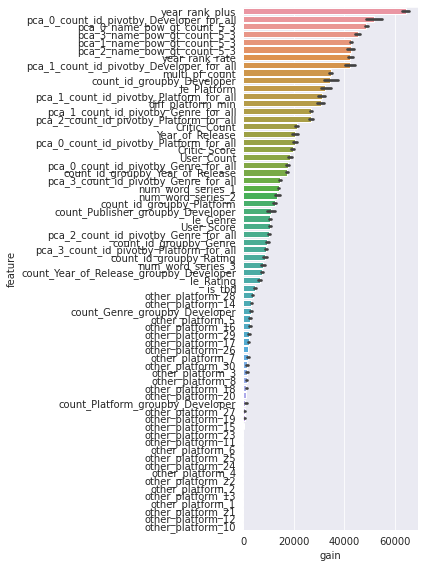

In [18]:
with logger.start(experiment_name=settings['competition'], run_name=settings['name']):
    oof, models, cv, importances = train(
        settings,
        logger,
        df_f_train,
        df_train,
        df_train.loc[:, 'target'].values,
        ckptdir
    )
    preds = predict(models, df_f_test, df_train, df_test)
#     sub_df = submit(preds, ckptdir)

In [ ]:
visualize_oof(np.expm1(df_train.loc[:, 'target'].values), np.expm1(oof))

In [19]:
preds.shape

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(8360, 49)

In [37]:
df_test

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id
0,Hitman 2: Silent Assassin,XB,NaN,Action,Eidos Interactive,84.0,23.0,8,19.0,Io Interactive,M,8359
1,Legacy of Kain: Soul Reaver,PS,NaN,Action,Eidos Interactive,91.0,17.0,9,132.0,Crystal Dynamics,T,8360
2,Metal Gear Solid 2: Substance,XB,NaN,Action,Konami Digital Entertainment,87.0,28.0,8.5,39.0,KCEJ,M,8361
3,Silent Hill: Homecoming,X360,NaN,Action,Konami Digital Entertainment,70.0,54.0,6.9,180.0,Double Helix Games,M,8362
4,Silent Hill: Homecoming,PS3,NaN,Action,Konami Digital Entertainment,71.0,41.0,6.9,143.0,Double Helix Games,M,8363
...,...,...,...,...,...,...,...,...,...,...,...,...
8355,SD Gundam G Generation Genesis,PSV,2016.0,Strategy,Namco Bandai Games,NaN,NaN,NaN,NaN,NaN,NaN,16714
8356,SD Gundam G Generation Genesis,PS4,2016.0,Strategy,Namco Bandai Games,NaN,NaN,NaN,NaN,NaN,NaN,16715
8357,Battle Worlds: Kronos,PC,2016.0,Strategy,Nordic Games,71.0,15.0,7.1,71.0,KING Art,NaN,16716
8358,Codename: Panzers Complete Collection,PC,2016.0,Strategy,Nordic Games,NaN,NaN,NaN,NaN,NaN,NaN,16717


In [36]:
le.inverse_transform(np.argmax(preds, -1)).tolist()

['Warner Bros. Interactive Entertainment',
 'Square Enix',
 'Take-Two Interactive',
 'Square Enix',
 'Square Enix',
 'Nintendo',
 'Atari',
 'Warner Bros. Interactive Entertainment',
 'THQ',
 'Nintendo',
 'Atari',
 'Vivendi Games',
 'Sony Computer Entertainment',
 'THQ',
 'Vivendi Games',
 'Vivendi Games',
 'Atari',
 'Nintendo',
 'Capcom',
 'Sony Computer Entertainment',
 'Warner Bros. Interactive Entertainment',
 'Capcom',
 'Sony Computer Entertainment',
 'Nintendo',
 'Sony Computer Entertainment',
 'Atari',
 'Atari',
 'Atari',
 'THQ',
 'Sony Computer Entertainment',
 'THQ',
 'THQ',
 'Majesco Entertainment',
 'Capcom',
 'Sony Computer Entertainment',
 'Sony Computer Entertainment',
 'THQ',
 'Atari',
 'Atari',
 'Atari',
 'Sony Computer Entertainment',
 'Atari',
 'Majesco Entertainment',
 'Sega',
 'Sega',
 'Atari',
 'MTV Games',
 'MTV Games',
 'MTV Games',
 'Atari',
 'Atari',
 'Nintendo',
 'Atari',
 'Atari',
 'Capcom',
 'Sony Computer Entertainment',
 'Capcom',
 'Majesco Entertainment',


In [31]:
argsort_pred = np.argsort(preds, -1)
argsort_pred

array([[23, 33,  9, ...,  4, 41, 47],
       [23,  9, 35, ..., 37, 46, 38],
       [23, 33,  9, ...,  4, 10, 43],
       ...,
       [35, 23,  9, ..., 36, 16, 34],
       [23, 33, 35, ..., 16, 43, 34],
       [35, 33, 23, ..., 31, 44, 10]])

In [33]:
argsort_pred[0] < 3

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [24]:
preds

array([[3.06306903e-03, 3.93593506e-04, 5.67752932e-04, ...,
        4.58508934e-02, 3.24468374e-01, 4.38585753e-04],
       [3.69197467e-03, 4.32791106e-04, 6.40887374e-04, ...,
        1.79209447e-01, 8.17534533e-03, 4.91627782e-04],
       [3.60170892e-03, 6.15651924e-04, 6.52463967e-04, ...,
        2.10300359e-02, 1.48707638e-02, 5.03609114e-04],
       ...,
       [3.48190655e-03, 7.51159519e-05, 7.01460410e-05, ...,
        3.31613340e-04, 7.02841593e-04, 4.93062465e-05],
       [2.96762026e-03, 2.75404886e-04, 2.11121085e-03, ...,
        1.60140870e-03, 3.69261665e-03, 3.06233216e-04],
       [3.08647889e-03, 5.90633065e-04, 2.09277361e-04, ...,
        8.41091267e-04, 2.09985479e-03, 5.44036511e-03]])

In [75]:
filename = 'country_prob_test'
df_test = pd.read_csv(datadir / f'{filename}.csv')
unk_index = df_test[(df_test['Publisher'] == 'Unknown') | (df_test['Publisher'].isna())].index
df_test.loc[unk_index, 'Publisher'] = le.inverse_transform(np.argmax(preds, -1))[unk_index]
df_test.to_csv(datadir / f'{filename}3.csv', index=False)

In [70]:
le.inverse_transform(np.argmax(preds, -1))[unk_index].shape

(255,)

In [71]:
df_test[df_test['Name'].fillna('NaN').str.contains('Mario')]

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id
178,Mario Tennis,3DS,NaN,Sports,Nintendo,NaN,NaN,NaN,NaN,NaN,NaN,8537
7329,Detective Conan: Marionette Symphony,3DS,2013.0,Adventure,Namco Bandai Games,NaN,NaN,NaN,NaN,NaN,NaN,15688


In [52]:
df_test.iloc[unk_index]

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id
5,Cubix Robots for Everyone: Clash 'n' Bash,GBA,NaN,Action,Nintendo,NaN,NaN,NaN,NaN,NaN,NaN,8364
8,Nicktoons: Battle for Volcano Island,GC,NaN,Action,THQ,NaN,NaN,7,4.0,Blue Tongue Entertainment,E,8367
12,Twisted Metal: Small Brawl,PS,NaN,Action,Sony Computer Entertainment,51.0,14.0,7.6,49.0,Incognito Inc.,T,8371
13,Teen Titans,GBA,NaN,Action,THQ,61.0,9.0,tbd,NaN,Artificial Mind and Movement,E10+,8372
16,Jurassic Park: The Game,X360,NaN,Action,Atari,60.0,9.0,3.6,138.0,Telltale Games,T,8375
17,WCW Backstage Assault,N64,NaN,Action,Nintendo,NaN,NaN,NaN,NaN,NaN,NaN,8376
24,Fullmetal Alchemist: Brotherhood,PSP,NaN,Action,Sony Computer Entertainment,NaN,NaN,NaN,NaN,NaN,NaN,8383
25,Super Duper Sumos,GBA,NaN,Action,Atari,57.0,5.0,tbd,NaN,Handheld Games,E,8384
26,Dinotopia: The Sunstone Odyssey,GC,NaN,Action,Atari,50.0,4.0,tbd,NaN,Vicious Cycle,T,8385
27,Aquaman: Battle for Atlantis,XB,NaN,Action,Atari,26.0,13.0,2.7,15.0,Lucky Chicken,T,8386
